Author: Minrui Li - Monash University

In [ ]:
# load library
import numpy as np
import pandas as pd
import math
from numpy import linalg as LA
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.graph_objs as go
import plotly

from sklearn import preprocessing # for normalisation

import itertools

In [4]:
# Unit vector in x direction
# column vector 
u = np.array([[1], [0], [0]])

## Functions

In [6]:
'''
from euler_2_matrix.txt
Function: euler angle to rotation matrix
Input: dataframe row tolist (Euler angle)
Output: 3 x 3 matrix

'''
def euler2rotMat(a_ncp, outputFile=False):
    a_row = a_ncp.copy()

    # degrees to radians
    a_row[0] = np.radians(a_row[0]) # tdrot
    a_row[1] = np.radians(a_row[1]) # tilt
    a_row[2] = np.radians(a_row[2]) # narot

    # cos/sin
    costdrot = np.cos(a_row[0])
    cosnarot = np.cos(a_row[2])
    costilt  = np.cos(a_row[1])
    sintdrot = np.sin(a_row[0])
    sinnarot = np.sin(a_row[2])
    sintilt  = np.sin(a_row[1])


    rotMat = np.zeros((3,3))
    rotMat[0,0] = costdrot*cosnarot - sintdrot*costilt*sinnarot
    rotMat[1,0] = - cosnarot*sintdrot - costdrot*costilt*sinnarot
    rotMat[2,0] = sinnarot*sintilt
    rotMat[0,1] = costdrot*sinnarot + cosnarot*sintdrot*costilt
    rotMat[1,1] = costdrot*cosnarot*costilt - sintdrot*sinnarot
    rotMat[2,1] = -cosnarot*sintilt
    rotMat[0,2] = sintdrot*sintilt
    rotMat[1,2] = costdrot*sintilt
    rotMat[2,2] = costilt

    rotMat = np.round_(rotMat, decimals = 6)

    if outputFile == True:
        rotMat = np.append(rotMat, [[a_row[3]], [a_row[4]], [a_row[5]]], axis=1)
    return rotMat

In [9]:
'''
Function: find orientation
Input: anlge (a list)
Output: orientation (a list)
'''
def orientation(angle):
    ff_ss = angle[0] < 45 or angle[0] > 135 # a1

    fs = not ff_ss

    ff = (angle[0] < 45 or angle[0] > 135) and (angle[1] < 45 or angle[1] > 135 or angle[2] < 45 or angle[2] > 135)
    ss = (not ff) and (not fs)

    if fs == 1:
        return "fs"
    elif ff == 1:
        return "ff"
    else:
        return "ss"
    #return [int(fs), int(ff), int(ss)]

In [8]:

'''
Function: find angle between neighbour
Input: dictionary, index of centre
Output: angle (a list)

idxx - current dictionary (current centered nucleosome)
dic - one of the inner dictionaries (a_dict[key])

Angle between centred NCP & i-th NCP
'''
def angle_nn(dic, idxxx):
    # angle list
    ang_list = []
    for j in range(len(dic["k_idx"])):

        if dic["k_idx"][j] != idxxx:
            # j-th NCP
            cos_alpha = round(np.dot(dic['transp'][0], dic['transp'][j]), 5) # NCP1 transpose * NCP j-th transpose
            cos_betai = round(np.dot(dic['normVec'].loc[dic["k_idx"][j]].tolist(), dic['transp'][0]), 5) # normalise vec *  NCP1/current key transpose 
            cos_betaj = round(np.dot(dic['normVec'].loc[dic["k_idx"][j]].tolist(), dic['transp'][j]), 5) # normalise vec *  NCP j-th transpose

            # angles
            a1 = math.degrees(math.acos(cos_alpha))

            a2 = math.degrees(math.acos(cos_betai))
            
            a3 = math.degrees(math.acos(cos_betaj))

            ang_list.append([a1, a2, a3])
        else:
            ang_list.append([0, 0, 0])
    return ang_list

In [12]:
'''
Function: read in data with distance setting and process as proper format
distance: in nm
scale: to nm
mode: csv or tbl or df
filename: string or dataframe

Output: a dictionary with all the information about neighbours
and extracted table from the dataset with additional information
e.g. number of neighbours of each nucleosome

Output dictionary can access individual nucleosome's dictionary via indexing
e.g. dictionary[1] 
'''

def readData(filename, distance, scale, mode='csv'):
    if mode == 'csv':
        df = pd.read_csv(filename, header=None)
    elif mode == 'tbl':
        df = pd.read_table(filename, delimiter=' ', header=None)
    elif mode == 'df':
        df = filename
    else:
        return "The file is invalid! Only tbl or csv can be accepted."

    # extract needed columns
    frames = [df.iloc[:, 6:9], df.iloc[:, 23:26], df.iloc[:, 9]]
    # len(frames)
    df1 = pd.concat(frames, axis=1)

    name_list = ['tdrot', 'tilt', 'narot', 'x', 'y', 'z', 'cc']
    # Rename column names
    df1.columns = name_list

    # Get distance to all the points and keep those within the range
    a_dict = {}
    for index, row in df1.iterrows():
        df3 = df1.copy()
        df3['dist'] = 0
        # current target index
        idxx = index
        # Calculate distance
        for indexx, roww in df1.iterrows():
            if indexx != idxx:
                df3.loc[indexx, 'dist'] = np.linalg.norm(roww[['x', 'y', 'z']] - df3.loc[idxx, ['x', 'y', 'z']]) * scale
        ## 20nm
        df3 = df3[df3['dist'] < distance] # 

        # Sort dataframe according to distance
        df3 = df3.sort_values(by=['dist'])

        # for central point
        # inner dictionary
        in_dict = {}

        in_dict["k_idx"] = list(df3.index) # row indices with distance less than defined distance
        in_dict["k_dist"] = list(df3.loc[list(df3.index), 'dist']) # list(a_dict["k_idx"], 'dist'])
        #print(in_dict["k_dist"])
        in_dict["xyz"] = df3.loc[in_dict["k_idx"], ["x", "y", "z"]] # k NCP's coordinates
        in_dict["euler"] = df3.loc[in_dict["k_idx"], ["tdrot", "tilt", "narot"]] # k NCP's euler angles

        in_dict['df'] = df3

        a_dict[index] = in_dict

    # angle, orientation
    for key in a_dict:
        # Find vector from neighbour to centre
        vec = a_dict[key]["xyz"] - a_dict[key]["xyz"].loc[key]
        normVec = vec.copy()
        # Find normalised vector
        ## replace the rows 
        norm_list = []
        for index, row in vec.iterrows():
            if index != key:
                normVec.loc[index] = row/np.linalg.norm(row)
            else:
                normVec.loc[index] = 0

        a_dict[key]["vector"] = vec
        a_dict[key]["normVec"] = normVec  
        #print("current dict: ", key)
        # Find transpose
        transp_list = []
        for i in range(len(a_dict[key]["k_idx"])): #YES
            # rotation matrix
            mati = euler2rotMat(a_dict[key]['euler'].loc[a_dict[key]["k_idx"][i]], outputFile=False) # NCP i-th
            # matarix * vector
            temp1 = list(np.dot(mati, u).transpose()[0]) # NCP1
            # transpose stored in dictionary
            transp_list.append(temp1) # a list of lists

        a_dict[key]['transp'] = transp_list # in the order of k_idx

        # Find angle
        # print("Current key", key)
        angles = angle_nn(a_dict[key], key)
        a_dict[key]['df']['orientation'] = 'centre'
        for i in range(len(a_dict[key]['k_idx'])):
            if a_dict[key]['k_idx'][i] != key:
                a_dict[key]['df'].loc[a_dict[key]['k_idx'][i], 'orientation'] = orientation(angles[i])
    
    df1['n_ncp'] = 0
    num_conn = []
    for key in a_dict:
        #for index, row in result[key]['df'].iterrows():
        num_conn.append(a_dict[key]['df'].shape[0]-1)
        df1.loc[key, 'n_ncp'] = (a_dict[key]['df'].shape[0] - 1)
    
    print("The data has been read successfully.")
    print("A dictionary containing neighbour information and a dataframe with extracted original data are returned.")
        
    return a_dict, df1


In [17]:
# FOR SUMMARY (NEW: with colours & axis labels)

'''
Function: plot summary (without duplicates)
Input: dictionary & dataframe from readData function
Output: angle (a list)


'''
def plotSummary(dictionary, df):
    points_x = []
    points_y = []
    points_z = []

    # store points in list (not neccessary here)
    for index, row in df.iterrows():    
        points_x.append(df.loc[index, 'x'])
        points_y.append(df.loc[index, 'y'])
        points_z.append(df.loc[index, 'z'])

    # without duplicates
    connection = []
    oriens = []

    # with duplicates
    conn = []
    orie = []

    con_ff = []

    con_ss = []

    con_fs = []

    # store orientation & start/end points
    for key in dictionary:
        for index, row in dictionary[key]['df'].iterrows():
            if index != key:
                a_tup = (key, index)
                orie.append(row['orientation'])
                conn.append(a_tup)

    # Find indicies of duplicates in connection
    dup_ind = []
    for i in range(len(conn)):
        temp = conn[i][1]
        if i != len(conn): # except the last one
            for j in range(i+1, len(conn)):
                if conn[j][0] == temp and conn[j][1] == conn[i][0]:# second half has issue??? connection[j][1] == i
                    dup_ind.append(j)
    # Remove duplicates
    for i in range(len(conn)):
        if i not in dup_ind:
            connection.append(conn[i])
            oriens.append(orie[i])
            if oriens[-1]=='ff':
                con_ff.append(conn[i])
            elif oriens[-1]=='ss':
                con_ss.append(conn[i])
            else:
                con_fs.append(conn[i])

    # store index of each orientation
    ff_idx = []
    ss_idx = []
    fs_idx = []
    for i in range(len(oriens)):
        if oriens[i] == 'ff':
            ff_idx.append(i)
        elif oriens[i] == 'ss':
            ss_idx.append(i)
        else:
            fs_idx.append(i)

    num_ori = [len(ff_idx), len(ss_idx), len(fs_idx)]
    ori = ['ff', 'ss', 'fs']
    bar_color = ['red', 'orange', 'blue']

    from matplotlib import pyplot as plt
    plt.barh(ori, num_ori, color=bar_color)
    plt.rcParams['font.size'] = '16'
    plt.xlabel("Count of orientations", fontsize=16)
    plt.ylabel("Orientation", fontsize=16)

    for index, value in enumerate(num_ori):
        plt.text(value, index,
                str(value))
    
    plt.show()

In [13]:
'''
Function: plot Edge (without duplicates)
Input: dictionary & dataframe from readData function 
& z_scale (maximum boundary of z direction for better visualisation in graph)
scale: pixel to nm or Angstrom scale

'''
def plotEdges(dictionary, df, z_scale, scale):

    # save different connections
    points_x = []
    points_y = []
    points_z = []

    count_ = []

    # store points in list
    for index, row in df.iterrows():    
        points_x.append(df.loc[index, 'x'] * scale)
        points_y.append(df.loc[index, 'y'] * scale)
        points_z.append(df.loc[index, 'z'] * scale)

        count_.append(df.loc[index, 'n_ncp'])
    # without duplicates
    connection = []
    oriens = []

    # with duplicates
    conn = []
    orie = []

    con_ff = []

    con_ss = []

    con_fs = []

    # store orientation & start/end points
    for key in dictionary:
        for index, row in dictionary[key]['df'].iterrows():
            if index != key:
                a_tup = (key, index)
                orie.append(row['orientation'])
                conn.append(a_tup)

    # Find indicies of duplicates in connection
    dup_ind = []
    for i in range(len(conn)):
        temp = conn[i][1]
        if i != len(conn): # except the last one
            for j in range(i+1, len(conn)):
                if conn[j][0] == temp and conn[j][1] == conn[i][0]:# second half has issue??? connection[j][1] == i
                    dup_ind.append(j)
    # Remove duplicates
    for i in range(len(conn)):
        if i not in dup_ind:
            connection.append(conn[i])
            oriens.append(orie[i])
            if oriens[-1]=='ff':
                con_ff.append(conn[i])
            elif oriens[-1]=='ss':
                con_ss.append(conn[i])
            else:
                con_fs.append(conn[i])
    # colour
    colours = []
    for orien in oriens:
        if orien == 'ff':
            colours.append('green')
        elif orien == 'ss':
            colours.append('red')
        else:
            colours.append('blue')

    # points
    trace1 = go.Scatter3d(
        x=points_x,
        y=points_y,
        z=points_z,
        mode='markers',
        name='points',
        marker=dict(size=2, # 2 6 count_+6 
                    color="black")  # black count_
    )

    # lines
    x_lines = list()
    y_lines = list()
    z_lines = list()

    #create the coordinate list for the lines
    for p in connection:
        for i in range(2):
            x_lines.append(points_x[p[i]])
            y_lines.append(points_y[p[i]])
            z_lines.append(points_z[p[i]])
        x_lines.append(None)
        y_lines.append(None)
        z_lines.append(None)

    trace2 = go.Scatter3d(
        x=x_lines,
        y=y_lines,
        z=z_lines,
        mode='lines',
        name='neighbours',
        marker=dict(color="#9A86A4")
    #    color = colours
    )

    # lines
    x_lines_ff = list()
    y_lines_ff = list()
    z_lines_ff = list()

    #create the coordinate list for the lines
    for p in con_ff:
        for i in range(2):
            x_lines_ff.append(points_x[p[i]])
            y_lines_ff.append(points_y[p[i]])
            z_lines_ff.append(points_z[p[i]])
        x_lines_ff.append(None)
        y_lines_ff.append(None)
        z_lines_ff.append(None)

    trace3 = go.Scatter3d(
        x=x_lines_ff,
        y=y_lines_ff,
        z=z_lines_ff,
        mode='lines',
        name='ff',
        marker=dict(color="red")
    #    color = colours
    )

    # lines
    x_lines_ss = list()
    y_lines_ss = list()
    z_lines_ss = list()

    #create the coordinate list for the lines
    for p in con_ss:
        for i in range(2):
            x_lines_ss.append(points_x[p[i]])
            y_lines_ss.append(points_y[p[i]])
            z_lines_ss.append(points_z[p[i]])
        x_lines_ss.append(None)
        y_lines_ss.append(None)
        z_lines_ss.append(None)

    trace4 = go.Scatter3d(
        x=x_lines_ss,
        y=y_lines_ss,
        z=z_lines_ss,
        mode='lines',
        name='ss',
        marker=dict(color="orange")
    #    color = colours
    )

    # lines
    x_lines_fs = list()
    y_lines_fs = list()
    z_lines_fs = list()

    #create the coordinate list for the lines
    for p in con_fs:
        for i in range(2):
            x_lines_fs.append(points_x[p[i]])
            y_lines_fs.append(points_y[p[i]])
            z_lines_fs.append(points_z[p[i]])
        x_lines_fs.append(None)
        y_lines_fs.append(None)
        z_lines_fs.append(None)

    trace5 = go.Scatter3d(
        x=x_lines_fs,
        y=y_lines_fs,
        z=z_lines_fs,
        mode='lines',
        name='fs',
        marker=dict(color="blue")
    #    color = colours
    )

    fig = go.Figure(data=[trace1, trace3, trace4, trace5])
    # no scale setting
    #fig.show(renderer="colab")
    # change z scale
    fig.update_layout(
    scene = dict(zaxis = dict(nticks=4, range=[0,z_scale], title="z-coordinates in nm"),
                 xaxis = dict(title="x-coordinates in nm"),
                 yaxis = dict(title="y-coordinates in nm")))
    fig.show()

In [18]:
#  (size & colour)
'''
Function: show Density Info (without duplicates)

dist - distance in nm
filter_n=0 - by default, all the points show in the graph
scale: pixel to nm or Angstrom scale

Output: show a 3D scatter plot & maximum number of neighbour
'''
def showDensityInfo(z_scale, distance, dictionary, df, scale, filter_n=0):

#    if zeroConnect == False: # only show points with connections
#        df = df[df['n_ncp']>0]
    volume = 4/3 * math.pi * (distance**3)
    volume = round(volume, 3)
    max_ncp = df['n_ncp'].max()
    density = round(max_ncp / volume, 3)
    
    # Error/warning if filter_n > maximum connection
    if filter_n > max_ncp:
        return_text = "Your filter is larger than the maximum number of neighbours!"
        return return_text
    else:
        df = df[df['n_ncp']>filter_n]   
    print(f"Information of density:\nMaximum neighbours: {max_ncp}.\n" +
          f"{df[df['n_ncp']== df['n_ncp'].max()].shape[0]} have maximum number of neighbours.\n") # +
          #f"This means that within a sphere of {volume} nm3, there are maximum {max_ncp} of neighbours of certain nucleosome.")
          
    points_x = []
    points_y = []
    points_z = []

    count_ = []
    # store points in list
    for index, row in df.iterrows():    
        points_x.append(df.loc[index, 'x'] * scale)
        points_y.append(df.loc[index, 'y'] * scale)
        points_z.append(df.loc[index, 'z'] * scale)

        count_.append(df.loc[index, 'n_ncp'])
    # without duplicates
    connection = []
    oriens = []
    # with duplicates
    conn = []
    orie = []

    con_ff = []

    con_ss = []

    con_fs = []
    # store orientation & start/end points
    for key in dictionary:
        for index, row in dictionary[key]['df'].iterrows():
            if index != key:
                a_tup = (key, index)
                orie.append(row['orientation'])
                conn.append(a_tup)

    # Find indicies of duplicates in connection
    dup_ind = []
    for i in range(len(conn)):
        temp = conn[i][1]
        if i != len(conn): # except the last one
            for j in range(i+1, len(conn)):
                if conn[j][0] == temp and conn[j][1] == conn[i][0]:# second half has issue??? connection[j][1] == i
                    dup_ind.append(j)
    # Remove duplicates
    for i in range(len(conn)):
        if i not in dup_ind:
            connection.append(conn[i])
            oriens.append(orie[i])
            if oriens[-1]=='ff':
                con_ff.append(conn[i])
            elif oriens[-1]=='ss':
                con_ss.append(conn[i])
            else:
                con_fs.append(conn[i])
    # colour
    colours = []
    for orien in oriens:
        if orien == 'ff':
            colours.append('green')
        elif orien == 'ss':
            colours.append('red')
        else:
            colours.append('blue')
    # points
    trace1 = go.Scatter3d(
        x=points_x,
        y=points_y,
        z=points_z,
        mode='markers',
        name='points',
        # change count_ to 2
        marker=dict(size=6, # 2 6 count_+6 
                    color=count_,
                    colorscale='Cividis_r', # Viridis Inferno Cividis_r BrBG
                    colorbar=dict(thickness=20, title= "Number of nucleosomes"))  # black
    )

    # no scale setting
    fig = go.Figure(data=[trace1])
    #fig.show(renderer="colab")

    # change z scale
    fig.update_layout(
    scene = dict(zaxis = dict(nticks=4, range=[0,z_scale], title="z-coordinates in nm"),
                 xaxis = dict(title="x-coordinates in nm"),
                 yaxis = dict(title="y-coordinates in nm")))

    fig.show()

In [19]:
'''
Function: plot cross correlation coefficient
Input: dataframe from readData function
scale: pixel to nm or Angstrom scale

Output: 3D scatter plot showing cross correlation coefficient

'''
def plotCC(df, z_scale, scale):

    points_x = []
    points_y = []
    points_z = []

    cc_ = []

    # store points in list
    for index, row in df.iterrows():    
        points_x.append(df.loc[index, 'x']*scale)
        points_y.append(df.loc[index, 'y']*scale)
        points_z.append(df.loc[index, 'z']*scale)

        cc_.append(df.loc[index, 'cc'])

    # Normalisation may not need

    cc_arr = np.array(cc_).reshape(-1,1)
    #print('Original List:', npl)
    scaler = preprocessing.MinMaxScaler()
    normalizedlist=scaler.fit_transform(cc_arr)
    #print('Normalized List:',normalizedlist)

    cc_list = normalizedlist.tolist()
    merged = list(itertools.chain.from_iterable(cc_list))
    merged = [np.round(num, 2) for num in merged]
    # points
    trace1 = go.Scatter3d(
        x=points_x,
        y=points_y,
        z=points_z,
        mode='markers',
        name='points',
        marker=dict(size=6, # 6 count_
                    color=cc_, # merged
                    colorscale= 'Cividis_r', # Cividis_r Viridis
                    colorbar=dict(thickness=20, title="Cross correlation coefficient")) #,
                    #opacity= merged)  # black
    )

    # no scale setting
    fig = go.Figure(data=[trace1])
    #fig.show(renderer="colab")
    # change z scale
    fig.update_layout(
    scene = dict(zaxis = dict(nticks=4, range=[0,z_scale], title="z-coordinates in nm"),
                 xaxis = dict(title="x-coordinates in nm"),
                 yaxis = dict(title="y-coordinates in nm")))
    fig.show()

In [20]:
'''
Function: output matrix filie with xyz from the table
Input: dataframe from readData function, matrix file name

'''
def outputMatFile(df, matrixFile):
    # matrix
    out_str = ''
    for i in range(len(df)):
        # convert to matrix
        mat = euler2rotMat(df.iloc[i].tolist(), outputFile=True)
        out_str = out_str + 'Model ' + format(i,".1f") + '\n'  # i instead of i+1
        # each row in matrix
        for j in range(mat.shape[0]):
            out_str = out_str + 7*' '
            out_str = out_str + format(mat[j, 0],".6f") + ' '
            out_str = out_str + format(mat[j, 1],".6f") + ' '
            out_str = out_str + format(mat[j, 2],".6f") + ' ' 
            out_str = out_str + format(mat[j, 3],".6f") + '\n'

    joined_str = ''.join(out_str)

    with open(matrixFile, 'w') as f:
        lines = f.write(joined_str)

## Execute function


In [14]:
dict_1, df_1 = readData(filename="t36_650_650_80_sl300.tbl", distance=20, scale=0.528, mode='tbl')
# t126_csv.csv, crop_table_t115.tbl

The data has been read successfully.
A dictionary containing neighbour information and a dataframe with extracted original data are returned.


In [15]:
df_1.shape

(445, 8)

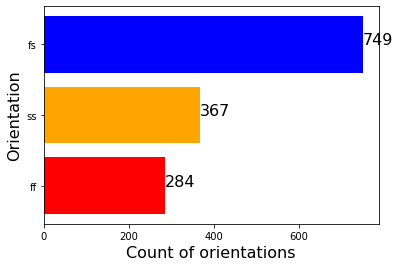

In [21]:
plotSummary(dict_1, df_1)

In [22]:
plotEdges(dict_1, df_1, z_scale=150, scale=0.528)

In [23]:
showDensityInfo(150, 20, dict_1, df_1, scale=0.528, filter_n=0)

Information of density:
Maximum neighbours: 15.
1 have maximum number of neighbours.



In [27]:
plotCC(df_1, z_scale=150, scale=0.528)

### Clustering

scale = 0.528

In [26]:
df_1['x_nm'] = df_1.x * 0.528
df_1['y_nm'] = df_1.y * 0.528
df_1['z_nm'] = df_1.z * 0.528

In [28]:
from sklearn.cluster import DBSCAN
import numpy as np
DBSCAN_cluster = DBSCAN(eps=20, min_samples=8).fit(df_1[['x_nm', 'y_nm', 'z_nm']]) 

In [29]:
df_1['labels'] = DBSCAN_cluster.labels_

In [30]:
# Show number of clusters & noise (label=-1)
df_1['labels'].value_counts()

 0    280
-1     60
 1     51
 2     32
 4     12
 3      8
 5      2
Name: labels, dtype: int64

In [31]:
# Without noise
import plotly.express as px

fig = px.scatter_3d(df_1[df_1['labels']!=-1], x='x_nm', y='y_nm', z='z_nm',
              color='labels')
fig.show()

In [32]:
# With noise
import plotly.express as px

fig = px.scatter_3d(df_1, x='x_nm', y='y_nm', z='z_nm',
              color='labels')
fig.show()

## Output file 

In [ ]:
# Convert xyz pixel to Angstrom!!
df_1['x'] = df_1['x'] * 5.28
df_1['y'] = df_1['y'] * 5.28
df_1['z'] = df_1['z'] * 5.28

In [ ]:
# output matrix
matrixFile = "slice_matrix.txt"
outputMatFile(df_1, matrixFile=matrixFile)

In [ ]:
# Output command
cmd_str = 'open'
# temp_str = r' C:\Users\Minrui\Desktop\NEW\invert_temp_8140.mrc' * len(df_1)
temp_str = r' /home/mlii0159/be57_scratch/Minrui/untitledFolder/slices/1kx4_template_orientation.pdb' * len(df_1)

# change the text file for different tables
# cmd_str = cmd_str + temp_str + '\n' + 'matrixset ' + r'C:\Users\Minrui\Desktop\NEW\matrix.txt' + '\n' + 'focus'
cmd_str = cmd_str + temp_str + '\n' + 'matrixset ' + r'/home/mlii0159/be57_scratch/Minrui/untitledFolder/slices/slice_matrix.txt' + '\n' + 'focus'

In [ ]:
# write command to text
with open('slice_script.txt', 'w') as f:
    lines = f.write(cmd_str)